In [59]:
import keras
import numpy as np
import time
import datetime

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


from tensorflow import keras as ks
from matplotlib import pyplot as plt

In [60]:
#Ajustamos la tasa de aprendizaje (learning rate) en función del valor de epoch
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [61]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Convertimos el tipo de datos de las imágenes (entrenamiento^prueba) de enteros a números de punto flotante (float32).
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

Para facilitar el entrenamiento de redes neuronales, calcula la media y la desviación estándar de los píxeles en el conjunto de entrenamiento y luego estandariza tanto los datos de entrenamiento como los de prueba para que tengan una distribución con media cero y desviación estándar uno.

In [62]:
# Z-score
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

In [63]:
#Codificación one-hot encoding, técnica utilizada clasificación multiclase

num_classes = 10
y_train = ks.utils.to_categorical(y_train, num_classes)
y_test = ks.utils.to_categorical(y_test, num_classes)

y_train
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [64]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


In [65]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))


Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


In [66]:
## Training and validation data division

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [67]:
# Definir el factor de regularización L2 deseado
l2_reg = 1e-5

model = Sequential()

# Capas de convolución con diferentes filtros y tasas de dropout
conv_architecture = [
    (32, (3, 3), 0.2),
    (32, (3, 3), 0.3),
    (64, (3, 3), 0.3),
    (64, (3, 3), 0.5),
    (128, (3, 3), 0.7)
]

for filters, kernel_size, dropout_rate in conv_architecture:
    # Aplicar regularización L2 en estas capas
    model.add(Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))


In [68]:
model.build(input_shape=(None, 32, 32, 3))

In [69]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_70 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_70 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_71 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_71 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                    

In [70]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

In [71]:
# Agregar Early Stopping
callback_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

In [72]:
t = time.perf_counter()

In [73]:
#Batch_size: el modelo procesará y actualizará los pesos basado en 64 ejemplos de entrenamiento.
batch_size = 64

# Optimizador
opt_rms = RMSprop(learning_rate=0.001, rho=0.9)

In [74]:
#'categorical_crossentropy': se utiliza cuando las etiquetas de clase se han convertido previamente en codificación "one-hot"
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt_rms,
    metrics=['accuracy'])

In [75]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), \
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=100, \
                    verbose=1, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/100
625/625 [==============================] - 36s 47ms/step - loss: 2.2744 - accuracy: 0.3172 - val_loss: 2.3800 - val_accuracy: 0.3797 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - 27s 44ms/step - loss: 1.5280 - accuracy: 0.4757 - val_loss: 1.2658 - val_accuracy: 0.5551 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - 27s 44ms/step - loss: 1.3279 - accuracy: 0.5451 - val_loss: 1.1123 - val_accuracy: 0.6021 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - 28s 44ms/step - loss: 1.2032 - accuracy: 0.5915 - val_loss: 1.0534 - val_accuracy: 0.6295 - lr: 0.0010
Epoch 5/100
625/625 [==============================] - 27s 44ms/step - loss: 1.1104 - accuracy: 0.6220 - val_loss: 0.9578 - val_accuracy: 0.6745 - lr: 0.0010
Epoch 6/100
625/625 [==============================] - 29s 46ms/step - loss: 1.0554 - accuracy: 0.6487 - val_loss: 0.9639 - val_accuracy: 0.6795 - lr: 0.0010
Epoch 7/100
625/625 [==============================]

In [77]:
# Evalúa el modelo en el conjunto de prueba con etiquetas en formato de valores enteros
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Imprime los resultados
test_loss_percentage = test_loss * 100
test_accuracy_percentage = test_accuracy * 100

print("Pérdida en el conjunto de prueba: {:.3f}".format(test_loss_percentage))
print("Precisión en el conjunto de prueba: {:.2f}%".format(test_accuracy_percentage))

313/313 [==============================] - 2s 5ms/step - loss: 0.5101 - accuracy: 0.8552
Pérdida en el conjunto de prueba: 51.012
Precisión en el conjunto de prueba: 85.52%


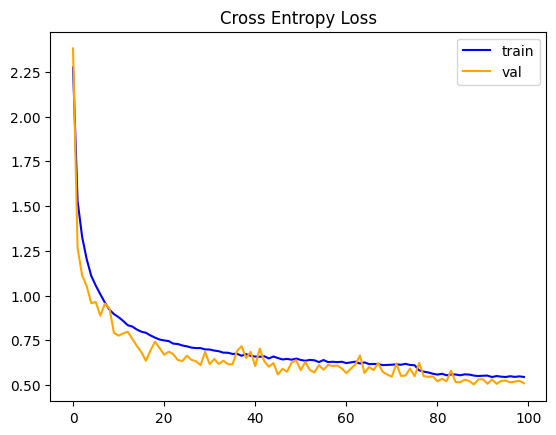

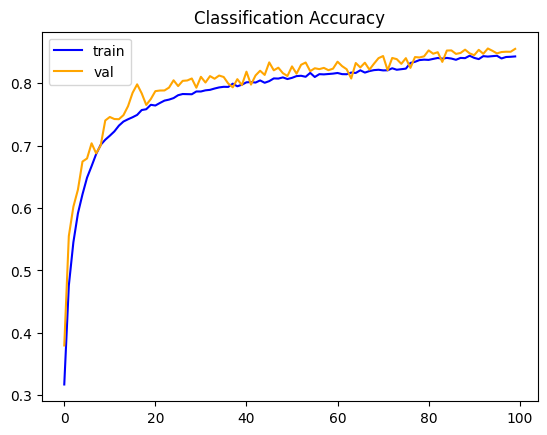

In [78]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()